### Load Selected Fakeddit Dataset and Create Dataloader

In [1]:
import pandas as pd
import os
import numpy as np
import transformers
from transformers import BertTokenizer
import warnings

warnings.filterwarnings("ignore") 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Dataset Config
DATASET_NUM_CLASSES = 3
DATASET_SIZE = "small"
DATASET_BASE_DIR = "../data/processed_data/" + str(DATASET_NUM_CLASSES) + "_classes_" + DATASET_SIZE
DATA_TYPE = "text_only" 

# BERT Config
PRE_TRAINED_MODEL_NAME = "bert-base-cased"
MAX_LEN = 512
BATCH_SIZE = 8
NUM_EPOCHES = 5
SAVE_PATH = "./trained_models/" + str(DATASET_NUM_CLASSES) + "_classes_" + DATASET_SIZE + "/bert_classification_models_" + DATA_TYPE + ".pth"
CONFUSION_MATRIX_PATH = "./trained_models/" + str(DATASET_NUM_CLASSES) + "_classes_" + DATASET_SIZE + "/confusion_matrix_" + DATA_TYPE + ".png"

In [2]:
train_data_raw = pd.read_csv(DATASET_BASE_DIR + "/train_data.csv")
test_data_raw = pd.read_csv(DATASET_BASE_DIR + "/test_data.csv")

In [3]:
train_data = train_data_raw[[DATA_TYPE, str(DATASET_NUM_CLASSES) + "_way_label"]]
test_data = test_data_raw[[DATA_TYPE, str(DATASET_NUM_CLASSES) + "_way_label"]]

In [4]:
train_data.rename(columns = {DATA_TYPE : "text", str(DATASET_NUM_CLASSES) + "_way_label" : "label"}, inplace = True)
test_data.rename(columns = {DATA_TYPE : "text", str(DATASET_NUM_CLASSES) + "_way_label" : "label"}, inplace = True)

In [5]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

#### Dataset Analysis

In [6]:
# import seaborn as sns
# import matplotlib.pyplot as plt

In [7]:
# token_lens = []
# for text in train_data.text:
#     tokens = tokenizer.encode(text, max_length = 1024, truncation=True)
#     token_lens.append(len(tokens))

In [8]:
# sns.displot(token_lens, kind="ecdf")
# plt.xlim([0, 512]);
# plt.xlabel('Token count');

#### Create Dataloader

In [9]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import weight_norm
import torch.optim.lr_scheduler as lr_scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
class FakedditDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        super(FakedditDataset, self).__init__()
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        label = torch.tensor(self.labels[item], dtype = torch.long)
        encoding = self.tokenizer.encode_plus(text, max_length=self.max_len, padding = "max_length",
                                              truncation=True, return_tensors="pt")
        return {
            "label": label,
            "attention_mask": encoding["attention_mask"].flatten(),
            "input_ids": encoding["input_ids"].flatten()
        }

In [11]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = FakedditDataset(
        texts = df.text.to_numpy(),
        labels = df.label.to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len
    )

    return DataLoader(ds, batch_size = batch_size, shuffle = True, num_workers = 0)

In [12]:
train_data_loader = create_data_loader(train_data, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_data, tokenizer, MAX_LEN, BATCH_SIZE)

In [13]:
sample_data = next(iter(train_data_loader))
print(sample_data["input_ids"].shape)
print(sample_data["attention_mask"].shape)
print(sample_data["label"].shape)

torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8])


### Define BERT Classification Model and Train

In [14]:
from transformers import BertModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm

2023-04-12 22:12:23.646083: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 22:12:29.856063: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/oracle/12.2/client64/lib/lib:/usr/local/lib::.
2023-04-12 22:12:29.856517: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/oracle/12.2/client64/lib/lib:/usr/local/lib::.
2023-04-12 22:12

In [15]:
class BERTForClassification(nn.Module):
    def __init__(self, num_classes):
        super(BERTForClassification, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p = 0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids = None, attention_mask = None):
        bert_outputs = self.bert(input_ids, attention_mask = attention_mask)
        pooled_outputs = self.drop(bert_outputs[1])
        out = self.fc(pooled_outputs)
        return out

In [16]:
def train_epoch(model, data_loader, loss_fn, optimizer, scheduler, device, n_examples):
    model = model.train()
    total_losses = 0
    correct_count = 0
    progress_bar = tqdm(enumerate(data_loader), total = len(data_loader))
    for idx, data in progress_bar:
        inputs = {"input_ids": data["input_ids"].to(device), "attention_mask": data["attention_mask"].to(device)}
        targets = data["label"].to(device)
        outputs = model(**inputs)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_count += torch.sum(preds == targets)
        loss.backward()
        total_losses += loss.item()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        progress_bar.set_description(f"loss:{loss.item():.4f}")

    return correct_count.double() / n_examples, total_losses / len(data_loader)

In [17]:
model = BERTForClassification(DATASET_NUM_CLASSES)
model = model.to(device)
optimizer = AdamW(model.parameters(), lr = 2e-5, correct_bias = False)
total_steps = len(train_data_loader) * NUM_EPOCHES
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps = total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
model.zero_grad()

for epoch in range(NUM_EPOCHES):
    print(f'Epoch {epoch+1}/{NUM_EPOCHES}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, scheduler, device, len(train_data))
    print('\n')
    print(f'Train loss: {train_loss}  Accuracy: {train_acc}')

Epoch 1/5
----------


loss:1.0982: 100%|███████████████████████████████████████████████████████████████████| 2152/2152 [28:17<00:00,  1.27it/s]




Train loss: 0.5183288739184021  Accuracy: 0.7894859134475748
Epoch 2/5
----------


loss:0.0054: 100%|███████████████████████████████████████████████████████████████████| 2152/2152 [28:13<00:00,  1.27it/s]




Train loss: 0.3127452826166792  Accuracy: 0.8991577112982864
Epoch 3/5
----------


loss:0.0046: 100%|███████████████████████████████████████████████████████████████████| 2152/2152 [28:15<00:00,  1.27it/s]




Train loss: 0.18025166885634117  Accuracy: 0.9558524542550101
Epoch 4/5
----------


loss:0.6730: 100%|███████████████████████████████████████████████████████████████████████| 2152/2152 [28:14<00:00,  1.27it/s]




Train loss: 0.09553492585112484  Accuracy: 0.97908800464711
Epoch 5/5
----------


loss:0.0003: 100%|███████████████████████████████████████████████████████████████████████| 2152/2152 [28:14<00:00,  1.27it/s]



Train loss: 0.05303718780100078  Accuracy: 0.9893697356956143


In [19]:
torch.save(model, SAVE_PATH)

### Evaluate BERT Classification Model

In [20]:
e_model = torch.load(SAVE_PATH, map_location=torch.device(device))

In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def eval_model(model, data_loader, device):
    model = model.eval()
    progress_bar = tqdm(enumerate(data_loader), total=len(data_loader))
    all_targets = []
    all_predictions = []
    for idx, data in progress_bar:
        inputs = {"input_ids": data["input_ids"].to(device), "attention_mask": data["attention_mask"].to(device)}
        targets = data["label"].to(device)
        probs = model(**inputs)
        _, preds = torch.max(probs, dim = 1)
        all_targets += targets.cpu().numpy().tolist()
        all_predictions += preds.cpu().numpy().tolist()
    print(classification_report(all_targets, all_predictions, digits = 5))
    ConfusionMatrixDisplay.from_predictions(all_targets, all_predictions, cmap = "GnBu")
    plt.savefig(CONFUSION_MATRIX_PATH)
    plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████| 228/228 [01:03<00:00,  3.61it/s]


              precision    recall  f1-score   support

           0    0.80551   0.79727   0.80137       587
           1    0.92287   0.89812   0.91033       373
           2    0.84439   0.86014   0.85219       858

    accuracy                        0.84763      1818
   macro avg    0.85759   0.85185   0.85463      1818
weighted avg    0.84794   0.84763   0.84771      1818



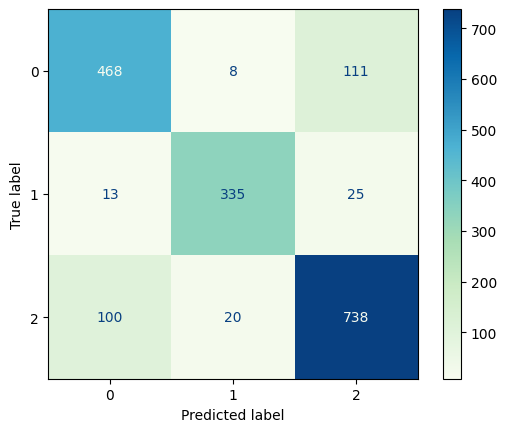

In [22]:
eval_model(e_model, test_data_loader, device)